Acceptance ratio: 0.54


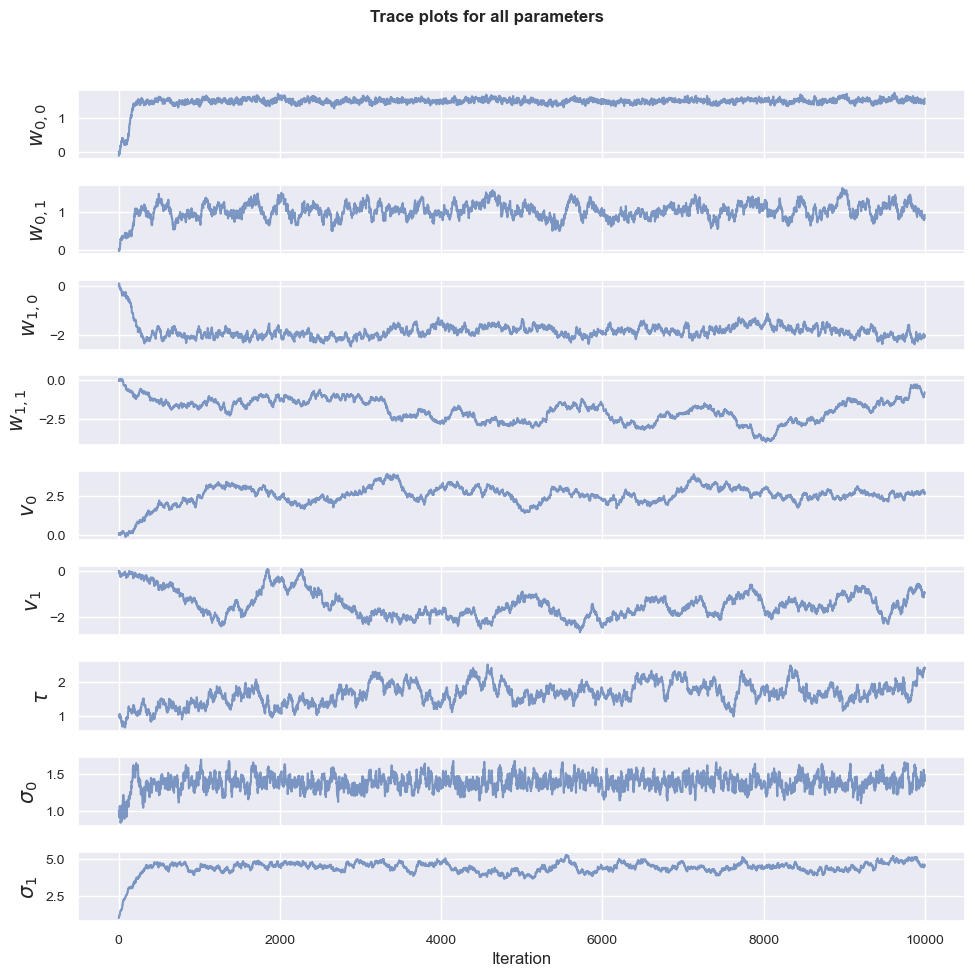

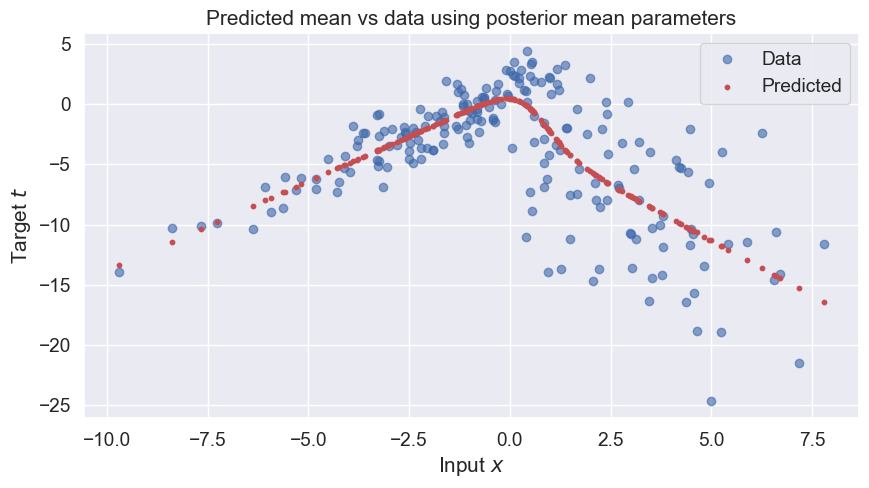

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as snb

# Load data
data = np.load("data_assignment3.npz")
x, y = data["x"], data["t"]
x = x.reshape(-1, 1)
x = np.hstack([x, np.ones((x.shape[0], 1))]) # Add column of ones

#---------------------
# Tasks 2.2 and 2.3
#---------------------

# === Define the log joint marginal likelihood ===
def log_joint_marginal_likelihood(theta, x, y):
    # Unpack model parameters
    w0, w1, v, tau, sigma0, sigma1 = theta

    # Compute gating probabilities: pi_n = σ(vᵀx_n)
    pi = 1 / (1 + np.exp(-x @ v))  # sigmoid

    # Compute predicted means for each expert
    mean0 = x @ w0
    mean1 = x @ w1

    # Log-likelihoods for each expert's Gaussian
    log_N0 = norm.logpdf(y, loc=mean0, scale=sigma0)
    log_N1 = norm.logpdf(y, loc=mean1, scale=sigma1)

    # Marginal log-likelihood using mixture of Gaussians
    log_likelihood = np.sum(np.log(pi * np.exp(log_N1) + (1 - pi) * np.exp(log_N0)))

    # Log priors: weights ∼ N(0, τ²)
    log_prior_w0 = np.sum(norm.logpdf(w0, 0, tau))
    log_prior_w1 = np.sum(norm.logpdf(w1, 0, tau))
    log_prior_v  = np.sum(norm.logpdf(v,  0, tau))

    # Log priors: τ, σ₀, σ₁ ∼ Half-Normal(0, 1)
    def log_half_normal(x): return np.log(2) + norm.logpdf(x, 0, 1) if x > 0 else -np.inf
    log_prior_tau   = log_half_normal(tau)
    log_prior_sig0  = log_half_normal(sigma0)
    log_prior_sig1  = log_half_normal(sigma1)

    # Return total log joint = log likelihood + log priors
    return (log_likelihood + log_prior_w0 + log_prior_w1 +
            log_prior_v + log_prior_tau + log_prior_sig0 + log_prior_sig1)

# === Flatten and unflatten theta ===
def unpack_theta(theta_flat):
    w0 = theta_flat[0:2]
    w1 = theta_flat[2:4]
    v  = theta_flat[4:6]
    tau, sigma0, sigma1 = theta_flat[6], theta_flat[7], theta_flat[8]
    return w0, w1, v, tau, sigma0, sigma1

def log_joint_wrapper(theta_flat):
    w0, w1, v, tau, sigma0, sigma1 = unpack_theta(theta_flat)
    if tau <= 0 or sigma0 <= 0 or sigma1 <= 0:
        return -np.inf
    return log_joint_marginal_likelihood([w0, w1, v, tau, sigma0, sigma1], x, y)

# === Metropolis-Hastings sampler ===
def metropolis(log_target, num_params, tau, num_iter, theta_init, seed=0):
    np.random.seed(seed)
    thetas = [theta_init]
    accepts = 0
    log_p_theta = log_target(theta_init)
    for _ in range(num_iter):
        theta_cur = thetas[-1]
        theta_star = theta_cur + tau * np.random.normal(size=num_params)
        log_p_star = log_target(theta_star)
        log_r = log_p_star - log_p_theta
        A = min(1, np.exp(log_r))
        if np.random.rand() < A:
            thetas.append(theta_star)
            log_p_theta = log_p_star
            accepts += 1
        else:
            thetas.append(theta_cur)
    print(f"Acceptance ratio: {accepts / num_iter:.2f}")
    return np.array(thetas)

# === Initialize and sample ===
theta_init = np.array([0, 0, 0, 0, 0, 0, 1.0, 1.0, 1.0])
samples = metropolis(log_joint_wrapper, num_params=9, tau=0.05, num_iter=10000, theta_init=theta_init)

# Continue with trace plots and predictions in the next step
samples.shape

# === Trace plots ===
param_names = [r"$w_{0,0}$", r"$w_{0,1}$", r"$w_{1,0}$", r"$w_{1,1}$",
               r"$v_0$", r"$v_1$", r"$\tau$", r"$\sigma_0$", r"$\sigma_1$"]

snb.set_style('darkgrid')
snb.set(font_scale=1.25)

fig, axs = plt.subplots(9, 1, figsize=(10, 10), sharex=True)
for i in range(9):
    axs[i].plot(samples[:, i], alpha=0.7)
    axs[i].set_ylabel(param_names[i])
    axs[i].tick_params(labelsize=10)
axs[-1].set_xlabel("Iteration", fontsize=12)
plt.suptitle("Trace plots for all parameters", fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for title
plt.show()

# === Posterior mean and predictions ===
mean_params = samples[5000:].mean(axis=0)  # using last 5000 samples (burn-in = 5000)
w0, w1, v, _, _, _ = unpack_theta(mean_params)
pi = 1 / (1 + np.exp(-x @ v))
mean0 = x @ w0
mean1 = x @ w1
y_pred = pi * mean1 + (1 - pi) * mean0

# === Plot predictions vs data ===
plt.figure(figsize=(10, 5))
plt.scatter(x[:, 0], y, label="Data", color="#3D67AA", alpha=0.6)
plt.scatter(x[:, 0], y_pred, label="Predicted", color="r", s=10)
plt.xlabel("Input $x$")
plt.ylabel("Target $t$")
plt.title("Predicted mean vs data using posterior mean parameters")
plt.legend()
plt.show()

In [2]:
#---------------------
# Tasks 2.4
#---------------------

# Use only post burn-in samples
posterior_samples = samples[5000:]

# Compute mean and 95% credibility intervals
posterior_mean = posterior_samples.mean(axis=0)
lower_bound = np.percentile(posterior_samples, 2.5, axis=0)
upper_bound = np.percentile(posterior_samples, 97.5, axis=0)

# Print results nicely
param_names = ["w0[0]", "w0[1]", "w1[0]", "w1[1]", "v[0]", "v[1]", "tau", "sigma0", "sigma1"]

print("Posterior Mean and 95% Credibility Intervals:\n")
for name, mean, low, high in zip(param_names, posterior_mean, lower_bound, upper_bound):
    print(f"{name:8}: {mean: .4f}  [{low: .4f}, {high: .4f}]")

Posterior Mean and 95% Credibility Intervals:

w0[0]   :  1.4859  [ 1.3715,  1.6189]
w0[1]   :  1.0397  [ 0.6688,  1.4151]
w1[0]   : -1.8271  [-2.2096, -1.4119]
w1[1]   : -2.1935  [-3.7759, -0.5453]
v[0]    :  2.5849  [ 1.7380,  3.4659]
v[1]    : -1.5223  [-2.3369, -0.7237]
tau     :  1.7598  [ 1.2854,  2.2875]
sigma0  :  1.3956  [ 1.2210,  1.5898]
sigma1  :  4.4672  [ 3.8985,  5.0620]


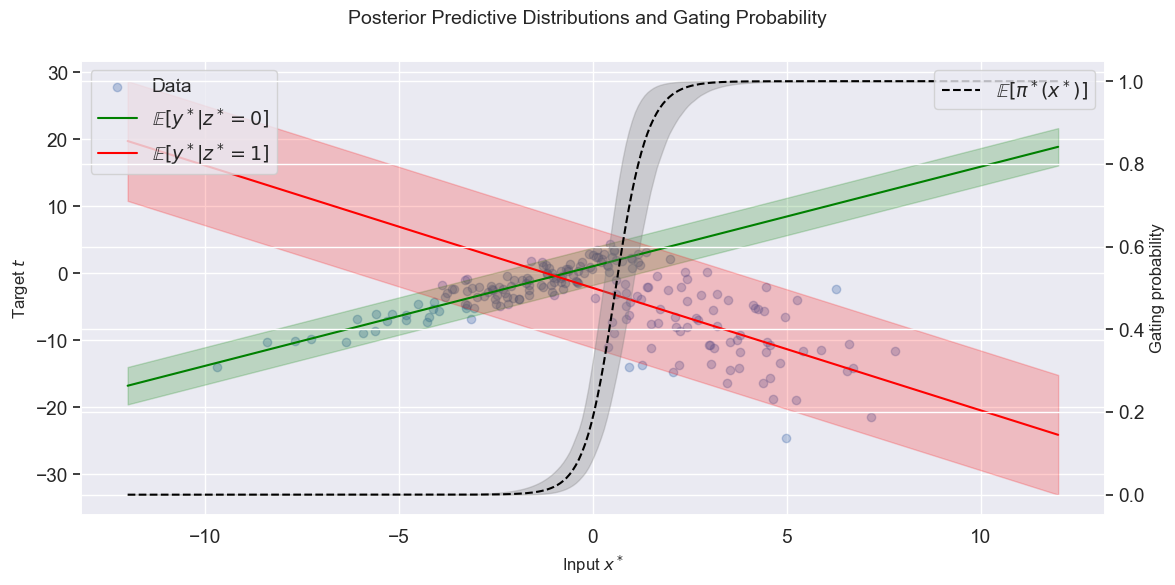

In [3]:

#---------------------
# Tasks 2.5
#---------------------

# Define test points
x_star = np.linspace(-12, 12, 300)
x_star_design = np.vstack([x_star, np.ones_like(x_star)]).T

# Storage
pi_star_all = []
mean0_all = []
mean1_all = []
std0_all = []
std1_all = []

# Loop through posterior samples
for theta in posterior_samples:
    w0, w1, v, _, sigma0, sigma1 = unpack_theta(theta)
    pi_star = 1 / (1 + np.exp(-x_star_design @ v))
    mean0 = x_star_design @ w0
    mean1 = x_star_design @ w1
    pi_star_all.append(pi_star)
    mean0_all.append(mean0)
    mean1_all.append(mean1)
    std0_all.append(np.full_like(x_star, sigma0))
    std1_all.append(np.full_like(x_star, sigma1))

# Convert to arrays
pi_star_all = np.array(pi_star_all)
mean0_all = np.array(mean0_all)
mean1_all = np.array(mean1_all)
std0_all = np.array(std0_all)
std1_all = np.array(std1_all)

# Compute posterior predictive means and intervals
pi_mean = pi_star_all.mean(axis=0)
pi_lower = np.percentile(pi_star_all, 2.5, axis=0)
pi_upper = np.percentile(pi_star_all, 97.5, axis=0)

mean0_mean = mean0_all.mean(axis=0)
mean1_mean = mean1_all.mean(axis=0)
std0_mean = std0_all.mean(axis=0)
std1_mean = std1_all.mean(axis=0)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot data
ax1.scatter(x[:, 0], y, alpha=0.3, label="Data", color="#3D67AA")

# Expert 0 prediction
ax1.plot(x_star, mean0_mean, color="green", label=r"$\mathbb{E}[y^* | z^*=0]$")
ax1.fill_between(x_star, mean0_mean - 2*std0_mean, mean0_mean + 2*std0_mean, color="green", alpha=0.2)

# Expert 1 prediction
ax1.plot(x_star, mean1_mean, color="red", label=r"$\mathbb{E}[y^* | z^*=1]$")
ax1.fill_between(x_star, mean1_mean - 2*std1_mean, mean1_mean + 2*std1_mean, color="red", alpha=0.2)

# Gating probability on secondary axis
ax2 = ax1.twinx()
ax2.plot(x_star, pi_mean, color="black", linestyle="--", label=r"$\mathbb{E}[\pi^*(x^*)]$")
ax2.fill_between(x_star, pi_lower, pi_upper, color="gray", alpha=0.3)
ax2.set_ylabel("Gating probability", fontsize=12)
ax2.set_ylim([-0.05, 1.05])

# Labels and legends
ax1.set_xlabel("Input $x^*$", fontsize=12)
ax1.set_ylabel("Target $t$", fontsize=12)
fig.suptitle("Posterior Predictive Distributions and Gating Probability", fontsize=14)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

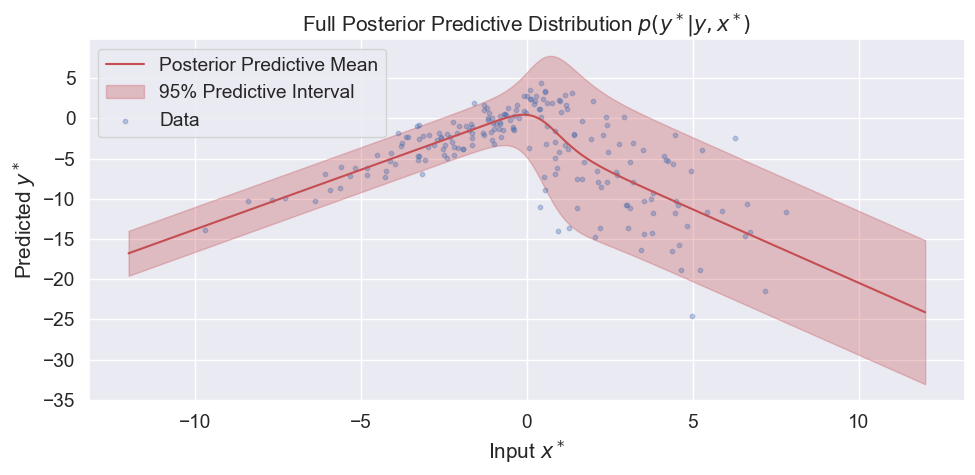

In [4]:
#---------------------
# Tasks 2.6
#---------------------

# Compute full posterior predictive distribution p(y* | y, x*)
y_star_means = []
y_star_vars = []

for theta in posterior_samples:
    w0, w1, v, _, sigma0, sigma1 = unpack_theta(theta)

    # Compute gating and means
    pi = 1 / (1 + np.exp(-x_star_design @ v))
    mu0 = x_star_design @ w0
    mu1 = x_star_design @ w1

    # Mixture mean and variance
    mean = pi * mu1 + (1 - pi) * mu0
    var = pi * (sigma1**2 + mu1**2) + (1 - pi) * (sigma0**2 + mu0**2) - mean**2

    y_star_means.append(mean)
    y_star_vars.append(var)

y_star_means = np.array(y_star_means)
y_star_vars = np.array(y_star_vars)

# Average over posterior samples
y_pred_mean = y_star_means.mean(axis=0)
y_pred_std = np.sqrt(y_star_vars.mean(axis=0))  # std from variance

# Plot posterior predictive distribution
plt.figure(figsize=(10, 5))
plt.plot(x_star, y_pred_mean, label="Posterior Predictive Mean", color="r")
plt.fill_between(x_star,
                 y_pred_mean - 2 * y_pred_std,
                 y_pred_mean + 2 * y_pred_std,
                 color="r", alpha=0.3, label="95% Predictive Interval")
plt.scatter(x[:, 0], y, color="#3D67AA", alpha=0.3, s=10, label="Data")
plt.xlabel("Input $x^*$")
plt.ylabel("Predicted $y^*$")
plt.title("Full Posterior Predictive Distribution $p(y^* | y, x^*)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()